<font size="6">Part I: Introduction</font>

# Causal Inference python packages

There are some (not too much) packages that implement algorithms to perform some tasks related to Causal Inference.

Nevertheless, the reality is: all of them are not too much mature. 


The most advanced once are:



## Causal ML from UBER

<img src="./images/causalml_logo.png" alt="Causal ML from Uber" title="" style="width: 200px" align="left"/>

<br>
<br>
<br>
<br>

You can find the github link [here](https://github.com/uber/causalml)

Directly from the project page:

"**Causal ML** *is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. It provides a standard interface that allows user to estimate the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE) from experimental or observational data. Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form.*"


You can find a lot of algorithms already implemented for modeling and estimation. 


## DoWhy from Microsoft

You can find the github [here](https://github.com/microsoft/dowhy) and the documentation [here](https://www.pywhy.org/dowhy/v0.9.1/user_guide/intro.html)

The authors describe the package as: *DoWhy | An end-to-end library for causal inference*

This affirmation is quite real since the package allows you to follow all the steps needed to perform a Causal Inference analysis.

The package has been designed to do the analysis in **four** different steps:


<img src="./images/dowhy_framework.png" alt="Causal ML from Uber" title="" />

### 1) Create the Causal Model

We know that in order to move from "association" to "causation" we need a plus of information, observational data is not enought. One way to represent this domain knowledge is through **causal graphs**.

DoWhy allows you to model those causal graphs and use them in during the whole process.

From the package page:

*"DoWhy creates an **underlying causal graphical model** for each problem. This serves to make each causal assumption explicit. This graph need not be complete—you can provide a partial graph, representing prior knowledge about some of the variables. DoWhy automatically considers the rest of the variables as potential confounders."*


### 2) Identification

Once we have created and defined the **causal model** is time to decide if the assumptions make sense. In other words, we have to **identify the causal model**:

*"Based on the causal graph, DoWhy finds all possible ways of identifying a desired causal effect based on the graphical model. It uses graph-based criteria and do-calculus to find potential ways find expressions that can identify the causal effect.*

In fact, our goal is to analyze our causal model (including the causal relationships between features and which features are observed) to determine whether we have enough information to answer a specific causal inference question.

Said in plain english: identification is the process of transforming a causal quantity to a statistical one, called the **identified estimand**.


### 3) Estimation

Once we found the **estimand**, it is time to **estimate** it. Because we were able to move from a causal quantity to a statistical one, we can use the **observational data** (a.k.a our database) to estimate the Treatment effect. At this stage, we can use **Machine Learning** methods to do this estimation.

There are several methods to do this estimation task. We'll go through some of them.


### 4) Refutation

Once we have an estimation, we have to be sure (or at least have some confidence on) that it make sense. DoWhy estimation is based in the **potential outcome** framework, so it is not possible to know if the results are actually good or not. The only think that we can do is to run some tests (called **refutation test**) that would give some hints about how good is our estimation.


Using this framework and the DoWhy package we can perform a complete Causal Inference analysis.

Let's see how it work with some examples




# Setting up the problem: Hotel Booking Cancellations


We consider what factors cause a hotel booking to be cancelled. This analysis is based on a hotel bookings dataset from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191). On GitHub, the dataset is available at [rfordatascience/tidytuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md). 

There can be **different reasons** for why a booking is cancelled:

- A customer may have requested something that was not available (e.g., car parking)
- a customer may have found later that the hotel did not meet their requirements
- or, a customer may have simply cancelled their entire trip. 

Some of these like car parking are actionable by the hotel whereas others like trip cancellation are outside the hotel's control. In any case, **we would like to better understand which of these factors cause booking cancellations**. 

The **gold standard** of finding this out would be to use experiments such as *Randomized Controlled Trials* wherein each customer is randomly assigned to one of the two categories i.e. each customer is either assigned a car parking or not. However, such an experiment can be **too costly** and also unethical in some cases (for example, a hotel would start losing its reputation if people learn that its randomly assigning people to different level of service). 

Can we somehow answer our query using only observational data or data that has been collected in the past?



In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)


In [3]:
!pip install scikit-learn==1.1.3
!pip install shap==0.38.1
!pip install dowhy
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pygraphviz

In [4]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Description

For a quick glance of the features and their descriptions the reader is referred here.
https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md

Spend 5 minutes to understand the different columns.

In [ ]:
dataset.columns

Let's see one single enty of the dataset:

In [ ]:
dataset.iloc[150]

In [ ]:
dataset.describe()

## Domain Knowledge

Represent your prior knowledge about the predictive modelling problem as a CI graph using assumptions. Don't worry, you need not specify the full graph at this stage. Even a partial graph would be enough and the rest can be figured out by *DoWhy* ;-)

Here are a list of assumptions that have then been translated into a Causal Diagram:-

- *Market Segment* has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).
- *Country* would also play a role in deciding whether a person books early or not (hence more *Lead Time*) and what type of *Meal* a person would prefer.
- *Lead Time* would definitely affected the number of *Days in Waitlist* (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher *Lead Times* can also lead to *Cancellations*.
- The number of *Days in Waitlist*, the *Total Stay* in nights and the number of *Guests* might affect whether the booking is cancelled or retained.
- *Previous Booking Retentions* would affect whether a customer is a *Repeated Guest* or not. Additionally, both of these variables would affect whether the booking get *cancelled* or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).
- *Booking Changes* would affect whether the customer is assigned a *different room* or not which might also lead to *cancellation*.
- Finally, the number of *Booking Changes* being the only confounder affecting *Treatment* and *Outcome* is highly unlikely and its possible that there might be some *Unobsevered Confounders*, regarding which we have no information being captured in our data.



<img src="./images/booking_cancellations_graph.png" alt="Causal Graph" title="" align="left"/>

Does our assumptions make sense? Let's do some analysis to confirm our intuitions

## Feature Engineering

Lets create some new and meaningful features so as to reduce the dimensionality of the dataset. 
- **Total Stay** =  stays_in_weekend_nights + stays_in_week_nights
- **Guests** = adults + children + babies
- **Different_room_assigned** = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

In [6]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']

# Total number of guests
dataset['guests'] = dataset['adults'] + dataset['children'] + dataset['babies']

# Creating the different_room_assigned feature
dataset['different_room_assigned'] = 0
slice_indices = dataset['reserved_room_type'] != dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned'] = 1

# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

We also remove other columns that either contain NULL values or have too many unique values (e.g., agent ID). We also impute missing values of the `country` column with the most frequent country. We remove `distribution_channel` since it has a high overlap with `market_segment`.

In [7]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)

# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [8]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

In [9]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print("Number of elements: %i" % len(dataset))
print(dataset.columns)
dataset.head()

Number of elements: 119386
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


We think that "non refund" and "refundable" are not interesting entries because they are underrepresented and probably not too much influencers

In [ ]:
dataset.deposit_type.hist()

In [ ]:
dataset = dataset[dataset.deposit_type=="No Deposit"]

Is the outcome variable too much unbalanced?

In [ ]:
dataset['is_canceled'].astype(int).hist()

In [ ]:
dataset.groupby(['deposit_type','is_canceled']).count()

At this step, we can think that one possible action (or treatment) that we can do is to offer to the customer other room than the selected one (maybe better). 

Let's understand a little bit more the data

In [ ]:
dataset['different_room_assigned'].astype(int).hist()

In [ ]:
dataset[dataset['different_room_assigned'] == True].is_canceled.astype(int).hist()

In [ ]:
dataset[dataset['different_room_assigned'] == False].is_canceled.astype(int).hist()

In [10]:
import scipy.stats

dataset_00 = dataset.copy()
dataset_00['different_room_assigned']= dataset_00['different_room_assigned'].replace(True,1)
dataset_00['different_room_assigned']= dataset_00['different_room_assigned'].replace(False,0)
dataset_00['is_canceled']= dataset_00['is_canceled'].replace(True,1)
dataset_00['is_canceled']= dataset_00['is_canceled'].replace(False,0)

x = dataset_00['different_room_assigned']
y = dataset_00['is_canceled']

r = scipy.stats.pearsonr(x, y)    # Pearson's r
rho = scipy.stats.spearmanr(x, y)   # Spearman's rho
tau = scipy.stats.kendalltau(x, y)  # Kendall's tau

/Users/ESMoraEn/miniforge3/envs/causalds/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [11]:
print(r)
print(rho)
print(tau)

PearsonRResult(statistic=-0.247761492345969, pvalue=0.0)
SignificanceResult(statistic=-0.24776149234597042, pvalue=0.0)
SignificanceResult(statistic=-0.2477614923459704, pvalue=0.0)


pssss... be careful, we are visualizing this distribution: 

$$ P \ ( \ is \ canceled \ | \ different \ room \ assigned \  ) $$

this is not the distribution that we want to calculte, is just only to gain intuition

In [ ]:
dataset_copy = dataset.copy(deep=True)

A very naive explanation could be that changing the room makes the cancellations go down... True or false?

## Calculating Expected Counts

First, is there any kind of relation between the **outcome (is_cancelled)** and the **treatment (different_room_assigned)** easy to find?

Let's do a couple of computations:

Since the number of number of cancellations and the number of times a different room was assigned is heavily imbalanced, we first choose 1000 observations at random to see that in how many cases do the variables; *'is_cancelled'* & *'different_room_assigned'* attain the same values. This whole process is then repeated 10000 times and the expected count turns out to be near 50% (i.e. the probability of these two variables attaining the same value at random).

In [ ]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

So **statistically speaking**, we have **no definite conclusion** at this stage. 

**Thus assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.**

We now consider the scenario when there were no booking changes and recalculate the expected count.

In [ ]:
# Expected Count when there are no booking changes 
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In the 2nd case, we take the scenario when there were booking changes(>0) and recalculate the expected count.

In [ ]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

There is definitely some change happening when the number of booking changes are non-zero. So it gives us a hint that *Booking Changes* must be a confounding variable.

But is *Booking Changes* the only confounding variable? What if there were some unobserved confounders, regarding which we have no information(feature) present in our dataset. Would we still be able to make the same claims as before?

## Can we predict a cancellation?

Maybe yes, but... knowing it would help me to understand if changing the room would affect the cancellations??

<font size="6">Part II: Enter *DoWhy*</font>

## Step-1. Create a Causal Graph


### Graphs in DoWhy

There are two different methods to describe a graph in DoWhy:

 - [GML - Graph Modeling Language](https://github.com/GunterMueller/UNI_PASSAU_FMI_Graph_Drawing) (preferred) 

 - [DOT](http://www.graphviz.org/documentation/) 
 
Take a look on this [notebook](https://microsoft.github.io/dowhy/example_notebooks/load_graph_example.html) to see some examples


In [12]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

### Important:

- Here the *Treatment* is **change room**. *Outcome* would be whether the booking was cancelled or not.
<br>
<br>
- *Common Causes* represent the variables that according to us have a causal affect on **both** *Outcome* and *Treatment*.
<br>
<br>
- As per our causal assumptions, the 2 variables satisfying this criteria are *Booking Changes* and the *Unobserved Confounders*.


Note: So if we are not specifying the graph explicitly (Not Recommended!), one can also provide these as parameters in the function mentioned below.

In [13]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)


dataset = dataset[dataset.deposit_type=="No Deposit"]




In [14]:
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [15]:
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


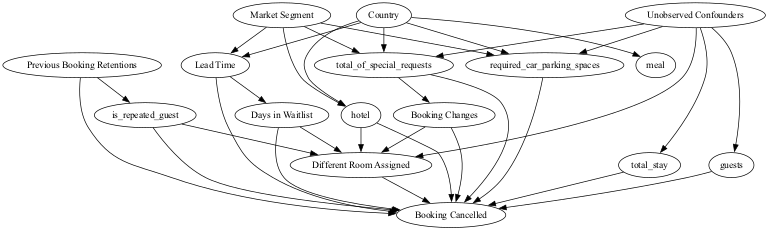

In [16]:
model = dowhy.CausalModel(
                          data = dataset,
                          graph = causal_graph.replace("\n", " "),
                          treatment = 'different_room_assigned',
                          outcome = 'is_canceled')
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png", width = 2000))

## Step-2. Identify the Causal Effect

Recall the Causal Effect definition: **Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant**.
Thus in this step, by using properties of the causal graph, we identify the causal effect to be estimated

To do that, DoWhy combines graph-based calculus and Pearl's do-calculus theory.

The main methods supported by the package are:

- Back-door criterion

- Front-door criterion

- Instrumental Variables

- Mediation (Direct and indirect effect identification)

Let's describe briefly the back-door criterion, since it is one of the most used 

### Backdoor criterion

Following the do-calculus rules we can write the *Adjustement Formula*

NOTE: don't look into the details, it is just informative

The idea is: I can calculate the effect of an intervetion *( $ do(A) $ )* using observational data conditioning on the proper variables and assuming that the modified graph is consistent.

<img src="./images/adjustement_formula.png" alt="Causal Ggraph" title="" style="width: 600px" align="left"/>

In other words: Intervening on **A** will have an effect on **B** that is *calculable from observational data* using the adjustment formula if we can find a **valid adjustment set Z**.

One way to identify a valid adjustment (Z) set is using the **back-door criterion**:

- Z blocks all paths between that A and B where the edge connected to A is directed at A.
- no descendants of A are in Z


Let's see some graph to illustrate the concept. Here the **X is the treatment** and **Y is the outcome**:

Simple graph:

<img src="./images/backdoor_1.png" alt="Causal Ggraph" title="" style="width: 400px"/>


But this one:

<img src="./images/backdoor_2.png" alt="Causal Ggraph" title="" style="width: 400px"/>

Look into the possible paths:

<img src="./images/backdoor_3.png" alt="Causal Ggraph" title="" style="width: 800px"/>

In [17]:
import statsmodels
model= dowhy.CausalModel(
        data = dataset,
        graph = causal_graph.replace("\n", " "),
        treatment = "different_room_assigned",
        outcome = 'is_canceled')

#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                             
──────────────────────────(E[is_canceled|lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,tot
d[different_room_assigned]                                                                                                                

                                               
al_of_special_requests,guests,booking_changes])
                                               
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,total_of_special_requests,guests,booking_changes,U) = P(is_canceled|different_room_assigned,lead_time,required_car_

## Step-3. Estimate the identified estimand

Once we have found strategies for identifying causal quantities, we need to choose how to estimate those causal quantities using statistical methods. After identification, estimation is the process of computing this quantity using available data.

A lot of different methods has been developed in order to estimate the identified estimad. Let's see a couple of them.


### Balance-based methods: simple stratification

For observational data, one of the most popular strategies to obtain an estimator is to directly approximate the back-door criterion.

To estimate the above expression, we need to create data subsets where **w** is constant. 

Balance-based methods try to attain covariate balance given the observed data so that the above equation can be estimated.

We can re-visit the backdoor estimand balance-based:

<img src="./images/balance-based backdoor.png" alt="" style="width: 600px" align="left" title="" />


A straight-forward way to estimate the back-door estimand is to estimate the conditional probabilities directly

<img src="./images/simple_stratification.png" alt="" title="" style="width: 600px" align="left"/>

Effectively, the method divides data into different strata, each having the same value of **w**. Then these estimates are summed up weighted by the number of data points in each strata, leading to a weighted average of the strata effects.

### Matching

When exact conditioning on **w** is not possible, either due to high-dimensionality or continuous variables, we can find units with as similar **w** as possible. A simple way is to define a metric of distance between any two units based on their **w** values.

### Propensity-based methods: propensity score

Ok, the real objetive is be able to make the *treatment t* independent of the confounders *w*. In the balance-based methods we are conditioning in the way that all the examples there have the same value of *w*, making them the treatment independent. Within the strate or pair, *t⫫w* and the units are said to be *balanced*.

There are alternative ways of ensuring balance that are effective for high-dimensional confounders.

More generally, any function  $ b: \Re^W \to \Re^K $

that ensures that *t* and *w* are independent

(i.e. given $ \ b(w) $ then, $ t⫫w \ | \ b(w) $ )

is called a **balancing function**.

Given a balancing score, the backdoor estimation equation can be rewritten as:

<img src="./images/propensity_score_1.png" alt="" title="" align="left" style="width: 600px" />

The most common balancing score is the propensity score, $ ps(w) = P( \ t \ | \ W = w) $, so called because it defines the propensity of treatment given values of $w$.

**In most cases the propensity score needs to be estimated**. Since both $t$ and $w$ are observed, it can be estimated using any supervised learning algorithm that returns a probability estimate of different outcome values.

In [18]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",
                                 target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                             
──────────────────────────(E[is_canceled|lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,tot
d[different_room_assigned]                                                                                                                

                                               
al_of_special_requests,guests,booking_changes])
                                               
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,total_of_special_requests,guests,bo

It means that having a different room assigned _decreases_ the chances of a cancellation. There's more to unpack here:

- Is this the correct causal effect? 
- Could it be that different rooms are assigned only when the booked room is unavailable, and therefore assigning a different room has a positive effect on the customer (as opposed to not assigning a room)?

There could also be other mechanisms at play:
- Perhaps assigning a different room only happens at check-in, and the chances of a cancellation once the customer is already at the hotel are low? In that case, the graph is missing a critical variable on _when_ these events happen. 
- Does `different_room_assigned` happen mostly on the day of the booking? Knowing that variable can help improve the graph and our analysis. 

Estimating the causal effect using DoWhy implies that a decision/policy to **reduce the number** of `different_room_assigned` at hotels may be counter-productive.

Why do you think that makes the causal effect so close to the associational one?

In [19]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate"
                                              )
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                             
──────────────────────────(E[is_canceled|lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,tot
d[different_room_assigned]                                                                                                                

                                               
al_of_special_requests,guests,booking_changes])
                                               
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,total_of_special_requests,guests,booking_

### Double ML

We can find a good explanation about the Double ML [here](https://econml.azurewebsites.net/spec/estimation/dml.html)

The main idea: 

Reduce the problem to first estimating two predictive tasks:

1. predicting the outcome from the controls,

2. predicting the treatment from the controls;

Then the method combines these two predictive models in a final stage estimation so as to create a model of the heterogeneous treatment effect.

With them we can compute the residuals:

<img src="./images/dml_residuals.png" alt="" title="" style="width: 400px" align="left"/>

In other words, the two residuals $r_t$ and $r_y$ represent the part of the treatment and outcome respectively that are not explained by the variation due to $w$. 

In other words, $r_t$ and $r_y$ are the *unconfounded* parts of the treatment and outcome.

A simple predictive model on these residual variables should yield the effect of treatment on the outcome.

<img src="./images/dml_final_model.png" alt="" title="" style="width: 400px" align="left"/>

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                             
──────────────────────────(E[is_canceled|lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,tot
d[different_room_assigned]                                                                                                                

                                               
al_of_special_requests,guests,booking_changes])
                                               
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,total_of_special_requests,guests,booking_changes,U) = P(is_canceled

In [21]:
print(len(dml_estimate.cate_estimates))
print(np.mean(dml_estimate.cate_estimates))

104637
-0.22077344826718967


###  Doubly robust ( too good to be real )

Doubly Robust Learning, similar to Double Machine Learning, is a method for estimating (heterogeneous) treatment effects *when the treatment is categorical* and all potential confounders/controls are observed, but are either too many (high-dimensional) for classical statistical approaches to be applicable or their effect on the treatment and outcome cannot be satisfactorily modeled by parametric functions (non-parametric).

Doubly robust is a generic method that given two possibly faulty ways of estimating a quantity, a doubly robust estimator guarantees an unbiased estimate, whenever one of them is correct.

Nice, right? 

It reduces the problem to first estimating two **predictive tasks**:

1. predicting the outcome from the treatment and controls

2. predicting the treatment from the controls

Then, we can create a new estimate (in a very smart way) that is able to do the estimation even if one of the other estimates fails. 

How: Let's go through a good explanation from [here](https://econml.azurewebsites.net/spec/estimation/dr.html) and [here](http://www.amitsharma.in/post/doubly-robust-estimation-a-simple-guide/).



In [22]:
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned,propensity_score,strata,dbar,d_y,dbar_y
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,0,0,0,2.0,False,0.340729,633.0,1,False,0
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,0,0,0,2.0,False,0.203299,527.0,1,False,0
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,0,1,1.0,True,0.333059,624.0,0,False,0
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,0,1,1.0,False,0.329668,620.0,1,False,0
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,1,2,2.0,False,0.256971,575.0,1,False,0


In [23]:
dataset_01 = dataset.copy()
dataset_01['different_room_assigned']= dataset_01['different_room_assigned'].replace(True,1)
dataset_01['different_room_assigned']= dataset_01['different_room_assigned'].replace(False,0)
dataset_01['is_canceled']= dataset_01['is_canceled'].replace(True,1)
dataset_01['is_canceled']= dataset_01['is_canceled'].replace(False,0)

In [24]:
model_dr = dowhy.CausalModel(
                            data = dataset_01,
                            graph = causal_graph.replace("\n", " "),
                            treatment = 'different_room_assigned',
                            outcome = 'is_canceled'
                            )

#Identify the causal effect
identified_estimand_dr = model_dr.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_dr)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                             
──────────────────────────(E[is_canceled|lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,tot
d[different_room_assigned]                                                                                                                

                                               
al_of_special_requests,guests,booking_changes])
                                               
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,total_of_special_requests,guests,booking_changes,U) = P(is_canceled|different_room_assigned,lead_time,required_car_

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

n = dataset_01.shape[0]
min_samples_leaf = int(n/100)

dr_estimate = model.estimate_effect(identified_estimand_dr, method_name="backdoor.econml.dr.DRLearner",
                                     control_value = 0,
                                     treatment_value = 1,
                                     target_units = "ate", 
                                     confidence_intervals=False,
                                     method_params={"init_params":{
                                         'model_regression':GradientBoostingRegressor(n_estimators=100,
                                                                                      max_depth=6,
                                                                                      min_samples_leaf=min_samples_leaf),
                                         'model_propensity': RandomForestClassifier(n_estimators=100,
                                                                                    max_depth=6,
                                                                                    min_samples_leaf=min_samples_leaf),
                                         'model_final': GradientBoostingRegressor(n_estimators=100,
                                                                                  max_depth=6,
                                                                                  min_samples_leaf=min_samples_leaf),
                                         'cv': 5,
                                                           },
                                                     "fit_params":{}})
print(dr_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                                                                             
──────────────────────────(E[is_canceled|lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,tot
d[different_room_assigned]                                                                                                                

                                               
al_of_special_requests,guests,booking_changes])
                                               
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,lead_time,required_car_parking_spaces,days_in_waiting_list,total_stay,hotel,is_repeated_guest,total_of_special_requests,guests,booking_changes,U) = P(is_canceled

## Step-4. Refute results

Note that the causal part does not come from data. It comes from your *assumptions* that lead to *identification*. Data is simply used for statistical *estimation*. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

What happens when another common cause exists?
What happens when the treatment itself was placebo?

**Supported refutation methods**

- **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

- **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)

- **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)

- **Simulated Outcome:** What happens to the estimated causal effect when we replace the dataset with a simulated dataset based on a known data-generating process closest to the given dataset? (Hint: It should match the effect parameter from the data-generating process)

- **Add Unobserved Common Causes:** How sensitive is the effect estimate when we add an additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? (Hint: It should not be too sensitive)

- **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

- **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

### Method-1
**Radom Common Cause:-** *Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn't change by much.*

In [26]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:-0.23105140132577376
New effect:-0.23872680061918505
p value:0.0



In [27]:
refute1_results=model.refute_estimate(identified_estimand, causal_estimate_dmatch,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:-0.26991408392824723
New effect:-0.2620543402429351
p value:0.0



In [ ]:
refute1_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="random_common_cause")
print(refute1_results)

In [ ]:
refute1_results=model.refute_estimate(identified_estimand, dr_estimate,
        method_name="random_common_cause")
print(refute1_results)


### Method-2
**Placebo Treatment Refuter:-** *Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.*

In [ ]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

In [ ]:
refute2_results=model.refute_estimate(identified_estimand, causal_estimate_dmatch,
        method_name="placebo_treatment_refuter")
print(refute2_results)

In [ ]:
refute2_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

### Method-3
**Data Subset Refuter:-** *Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn't be much variation.*

In [ ]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)